In [2]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# !ls pubmed-rct

In [3]:
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as plt

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [5]:
# Create function to read data 
def get_lines(filename: str):
    """
    Reads filename (a text filename) and returns the lines of text from input file name
    """
    with open(filename, "r") as file:
        return file.readlines()
        
        
train_lines  = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
len(train_lines)

210040

In [7]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [8]:
# Get data from file and preprocess it
# %%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [9]:
train_samples[:2]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11}]

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [11]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

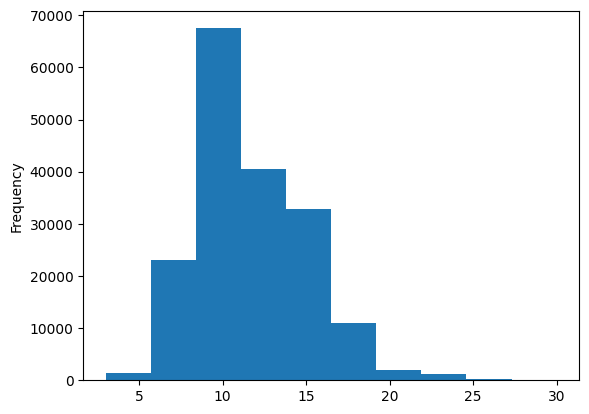

In [12]:
train_df.total_lines.plot.hist();

# Get list of sentences

In [13]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Make numeric labels

Create one hot and label encoded labels.
To numerically encode label we'll use Scikit-Learn's OneHotEncoder and LabelEncoder

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# tranning labels
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

# Label encode labels

In [15]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Createing a series of model experiments

# 0. Getting a baseline

 - First model we'll be a TF-IDF Multinomial Naive Bayes as recommended.
 - Create a Scikit-Learn Pipeline which use:
     + TfidfVectorizer to convert our abstract sentences to numbers using the TF-IDF algorithm.
     + learns to classify our sentences using the MultinomialNB algorithm.
    

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the traning data
model_0.fit(X=train_sentences, 
           y=train_labels_encoded)



Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
# Evaluate baseBase line model

model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [19]:
baseline_preds = model_0.predict(X=val_sentences)

In [20]:
from helper_functions import calculate_results

baseline_result = calculate_results(y_true=val_labels_encoded,
                                  y_pred=baseline_preds)

baseline_result

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Preparing our data for deep sequence models

- Create vectorization and embedding layyers.
    - The vectorization will convert our text to numbers.
    - The embedding layers will capture the relationships between those numbers.

Since we will be turning our sentences into number, it's a good idea to figure out how many words are in each sentence.

When out model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight wors long and another is 29 words long, we want to pad the eight word sentence with zores so it ends up being the same length as the 29 word sentence.

Looks like the vast majority

In [22]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]  # list of len from train_sentence
avg_sent_len = np.mean(sent_lens)
avg_sent_len # avenger len train sentence

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

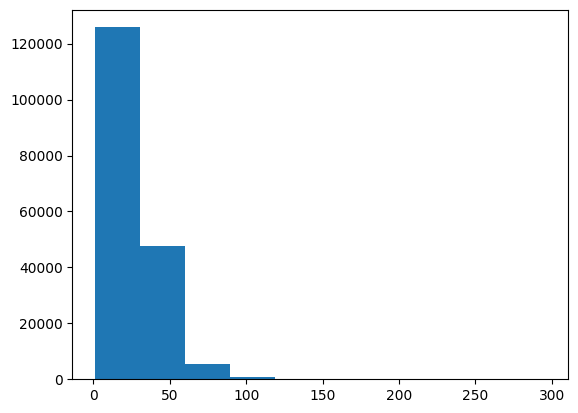

In [23]:
# distribution of train sentence
import matplotlib.pyplot as plt
plt.hist(sent_lens)

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use Numpy's percentile to find the value which covers 95% if the sentence lengths

In [24]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

When we create our tokenization layer, we will usethis value to turn all of our sentences into the same length. Meaning sentences with a length below 55 padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros ( sinces all sentences below the max length woud get padded with zeros).

### Create text vectorizer

Create a way to turn it into numbers.

We will use the `TextVectorization` layer from TensorFlow.

We will keep all the parameters default except for `max_tokens` (the number of unique words in our 
dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [25]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our `output_sequence_length` parameter.

In [26]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens= max_tokens, # number of words in vocabulary
                                   output_sequence_length=55 # desired output length of vectorized sequences
                                   ) 

let's adapt it to the trainning data (let it read the training data and figure out what number should represent what word)

In [27]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [28]:
# Test our text vectorizer
import random 
target_sentence = random.choice(train_sentences)
target_sentence, len(target_sentence.split()), text_vectorizer([target_sentence])

('thirteen physically active males completed two @-d supplemental periods , in a double-blind , randomized crossover design separated by a @-week washout period .',
 24,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[5399, 3685,  327, 1037,  253,   51,  187, 3047, 1242,    5,    8,
          236,   29,  484,  372, 2652,   22,    8,   89, 1611,  173,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int64)>)

------------------------------------------------------------------
In our `text_vectorizer` object we can use:
    
    - method `get_vocabulary()` to find out a few different tidbits about our text.
    
    - method `get_config()` to find out the configuration.

In [29]:
# How many words in our training vocabulary? 
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
# look count of words in our training vocabulary, most common words and the least common words
len(rct_20k_text_vocab), rct_20k_text_vocab[:5], rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [30]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

 ### Create custom text embedding 

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture he relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's `Embedding` layer.

Once again, the main parameters we are concerned with here are the inputs and outputs of our Embedding layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [31]:
# Create token embedding layer
from tensorflow.keras import layers 
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vacabulary
                              output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                              # Use masking to handle variable sequence lengths (save space)
                              mask_zero=True,
                              name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
thirteen physically active males completed two @-d supplemental periods , in a double-blind , randomized crossover design separated by a @-week washout period .

Sentence after vectorization (before embedding):
[[5399 3685  327 1037  253   51  187 3047 1242    5    8  236   29  484
   372 2652   22    8   89 1611  173    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.02602674  0.01222041  0.0164856  ... -0.02196503  0.04337389
   -0.00927194]
  [-0.02536449 -0.01161823 -0.01263221 ... -0.02235607  0.04038953
    0.01290821]
  [ 0.00937573  0.02584222 -0.03301819 ...  0.03798226 -0.0299369
    0.03172499]
  ...
  [ 0.04108028  0.0236468  -0.03827355 ... -0.00218865 -0.03547467
    0.03662336]
  [ 0.04108028  0.0236468  -0.03827355 ... -0.00218865 -0.03547467
    0.03662336]
  [ 0.04108028  0.0236468 

----------------------------------------------------------
## Create datasets

We have gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data` API provides methods which enable faster data loading.

The main steps we will want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we will ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [32]:
# Turn out data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [33]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

We have now get a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:
    
    `Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)` 
    
The main component we will be changing throughout is the `Layers` component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model is a 1-dimensional Convolutional Neural Network. And following the standardmachine learning workflow of:
    
    - Build model
    
    - Train model
    
    - Evaluate model (make predictions)

In [34]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile 
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

--------------------------------------------

First deep sequence model build and ready to go.

Checking out the model summary, you will notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter of the `Embedding` layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we are going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we are going to run them on a subet of the training dataset.

More specifically, we will only use the first 10% of batches (about 18,000 samples) of the  training set to train on and the first 10% of batches from the validation set to validate on.

In [35]:
model_1_history = model_1.fit(train_dataset,
                             steps_per_epoch= int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)),
                             verbose=1)

Epoch 1/3
562/562 [==============================] - 48s 84ms/step - loss: 0.9167 - accuracy: 0.6381 - val_loss: 0.6883 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 48s 85ms/step - loss: 0.6598 - accuracy: 0.7562 - val_loss: 0.6393 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 49s 87ms/step - loss: 0.6192 - accuracy: 0.7726 - val_loss: 0.5969 - val_accuracy: 0.7842


In [36]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.5984 - accuracy: 0.7867


[0.598419189453125, 0.7867403626441956]

In [37]:
model_1_pred_probs = model_1.predict(valid_dataset)

945/945 [==============================] - 2s 2ms/step


In [38]:
# Convert predict probability to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [39]:
# Calculate model_1 result 
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.67403680656693,
 'precision': 0.7833394981684093,
 'recall': 0.7867403680656693,
 'f1': 0.7843559401517408}

-----------------------------------------------------------------------------
### Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.

The model structure will look like:

` Inputs (string) -> Pretrained embeddings from TensorFlow Hub ( Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)`

You will notice the lack of tokenization layer we have used in a previous model. This is because the Universal Sentence Encoder (USE) take care of tokenization for us.

This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words taking the patterns a model has learned elsewhere and applyinh it to our own problem.

![TensorFlow Hub Universal Feature Encoder feature extractor model we're building](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-model-tf-hub-USE-to-dense-layer.png)
*The feature extractor model we're building using a pretrained embedding from TensorFlow Hub.*

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We will keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainadble couple of layers on the top to tailor the model outputs to our own data.


In [40]:
# Download pretrained TensoFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       trainable=False,
                                       name="universal_sentence_encoder")


Beautiful, now our pretrained USE is downloaded and instantiated as a `hub.KerasLayer` instance, let is test it out on a random sentence.

In [41]:
import random
# Test out the embedding on a random sentence
random_trainning_sentence = random.choice(train_sentences)
use_embedded_sentence = tf_hub_embedding_layer([random_trainning_sentence])
random_trainning_sentence, use_embedded_sentence[0][:30], len(use_embedded_sentence[0])

("we developed a `` pediatric advanced life support-reconstructed '' recertification course by deconstructing the training into six @-minute in situ simulation scenario sessions delivered over @ months .",
 <tf.Tensor: shape=(30,), dtype=float32, numpy=
 array([-0.01821046,  0.02134912, -0.0583396 , -0.04529253, -0.07799703,
         0.03063689, -0.02572216,  0.00589463,  0.01647951, -0.02022798,
         0.06665286,  0.00391623,  0.02875149,  0.04661667,  0.04535261,
        -0.00246954, -0.06207876,  0.06132438, -0.05601048, -0.06334782,
         0.00870684,  0.05193744, -0.03125134,  0.01636303,  0.02240308,
        -0.01020966, -0.03325118, -0.01297997, -0.06078208, -0.05840213],
       dtype=float32)>,
 512)

Pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

----------------------------------------------------

** Building and fitting an NLP feature extraction model from TensorFlow Hub **

In [42]:
# Define feature extractor model using TF Hub Layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding 
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


In [43]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set `training=False` when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [44]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)),
           epochs=3,
           validation_data=valid_dataset,
           validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 0.9202 - accuracy: 0.6505 - val_loss: 0.7958 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7691 - accuracy: 0.7028 - val_loss: 0.7552 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7527 - accuracy: 0.7117 - val_loss: 0.7388 - val_accuracy: 0.7141


In [45]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.7412 - accuracy: 0.7138


[0.7412346601486206, 0.7137892246246338]

In [46]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
# Calculate results from TF Hb pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

945/945 [==============================] - 5s 5ms/step


{'accuracy': 71.37892228253673,
 'precision': 0.7144465894612892,
 'recall': 0.7137892228253674,
 'f1': 0.7107138937566347}


**Model 3: Conv1D with character embeddings**

**Creating a character-level tokenizer**

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We have build models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the character embedding is created using sequences split into characters(hello -> [h,e,l,l,o]) where as a token embedding is created on sequences spilt into tokens.

Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

We can create a character-level embedding by first vectorizing our sequences (after they have been split into characters) using the `TextVectorization` class and them passing those vectorized sequences through an Embedding layer.

Before we can vectorized our sequences on a character-level we will need to split them into characters. Let's write a function todo so.

In [47]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

Our character-splitting function works. Let's create character-level datasets by splitting our sequence datasets into characters.

In [48]:
# Split sequence-level data into character-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [49]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

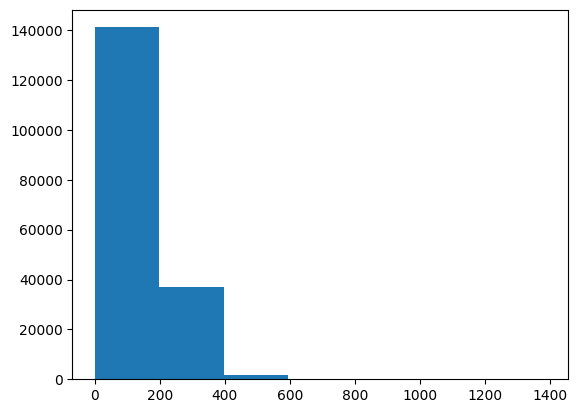

In [50]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [51]:
# Find what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

We will use that in `TextVectorization` layer as the `output_sequence_length` parameter.
We will set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [52]:
# Get all keyboard characters for  char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [53]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

adapted our `char_vectorizer` to out character-level sequences, check the result with `get_vocabulary()` method.

In [54]:
# Check character vocabylary characteristics
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [55]:
random_train_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_train_chars])
random_train_chars, len(random_train_chars.split()), vectorized_chars, len(vectorized_chars[0])

('a t   b a s e l i n e   a d o l e s c e n t s   w e r e   p r e s c r i b e d   m e t f o r m i n   a n d   r a n d o m i s e d   t o   o n e   o f   t w o   e n e r g y   r e s t r i c t e d   d i e t s   .',
 89,
 <tf.Tensor: shape=(1, 290), dtype=int64, numpy=
 array([[ 5,  3, 22,  5,  9,  2, 12,  4,  6,  2,  5, 10,  7, 12,  2,  9,
         11,  2,  6,  3,  9, 20,  2,  8,  2, 14,  8,  2,  9, 11,  8,  4,
         22,  2, 10, 15,  2,  3, 17,  7,  8, 15,  4,  6,  5,  6, 10,  8,
          5,  6, 10,  7, 15,  4,  9,  2, 10,  3,  7,  7,  6,  2,  7, 17,
          3, 20,  7,  2,  6,  2,  8, 18, 19,  8,  2,  9,  3,  8,  4, 11,
          3,  2, 10, 10,  4,  2,  3,  9,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
    

--------------------------------------------
You will notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the `standardize` parameter of `TextVectorization` being `"lower_and_strip_punctuation"` and the `split` parameter being `"whitespace"` by default, sysbols (such as `@`) and spaces are removed.

---------------------------------------------
### Creating a character-level embedding

We have got a way to vectorize our character-level sequences, now's time to create a character-level embedding. 

Just like our custom token embedding, we can do so using the `tensorflow.keras.layers.Embedding` class.

Our character-level embedding layer requires an input demension and output dimension. The input dimension (input_dim) will be equal to the number of different characters in our `char_vocab`(28). And since we are following the structure of the model in Figure 1 of Neural Netwoks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (`output_dim`) will be 25

In [56]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                             output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                             mask_zero=False,
                             name="char_embed")
char_embed(char_vectorizer([random_train_chars]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.02689884,  0.02409115,  0.03466495, ..., -0.02685288,
         -0.03494097, -0.00963682],
        [ 0.01821453, -0.04945204, -0.03118258, ...,  0.02520032,
          0.04411751,  0.02734579],
        [-0.02232257,  0.03401503,  0.02266918, ...,  0.02432853,
         -0.00098894, -0.02169842],
        ...,
        [ 0.00684003,  0.00759763,  0.02577894, ...,  0.02109616,
         -0.0069389 , -0.01705234],
        [ 0.00684003,  0.00759763,  0.02577894, ...,  0.02109616,
         -0.0069389 , -0.01705234],
        [ 0.00684003,  0.00759763,  0.02577894, ...,  0.02109616,
         -0.0069389 , -0.01705234]]], dtype=float32)>

each of the characters in our sequences gets turned into a 25 dimension embedding.

-----------------------------------------------
### Build a Conv1D model to fit on character embeddings.

We have got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`) let's test how efective they are at encoding the information in out sequences by creating a charater-level sequence model.

The model will have the same structure as out custom token embedding model(`model_1`) except it will take character-level sequences as input instead of token-level sequences.

    Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [57]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

Create char-level batched with `PrefetchedDataset` 

In [58]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [59]:
# Fit the model on chars only
# Using 10% of batches
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_dataset)),
                             epochs=3,
                             validation_data=val_char_dataset,
                             validation_steps=int(0.1 * len(val_char_dataset)),
                             verbose=0)

In [60]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.8996 - accuracy: 0.6523


[0.8996216654777527, 0.6523236036300659]

Looks like our character-level model is working, let's make some predictions with it and evaluate them.

In [61]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 0], dtype=int64)>

In [62]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded, 
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 65.23235800344234,
 'precision': 0.6433533220472819,
 'recall': 0.6523235800344234,
 'f1': 0.6425671637553484}

--------------------------------------

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tachled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we have build two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we have going to go through the following steps:

    1. Create a token-level model(similar to model_1)
    2. Create a character-level model
    3. Combine (using layers.Concatenate) the outputs of 1 and 2
    4. Build a series of output layers on top of 3 similar
    5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.    

In [63]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_output)

# 2. Setup character inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name="model_4_token_and_char_embeddings")


Get summary and plot the model to visualize.

    model_4.summary()

    from tensorflow.keras.utils import plot_model
    plot_model(model_4)

In [64]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

And again, to keep our experiments fast, we will fit our token-character-hybrid model on 10% of trainning and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:

    - ((token_data, char_data), (label))
    
See in action.

### Combining token and character data into a `tf.data` dataset.

In [65]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [67]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                             validation_data=val_char_token_dataset,
                             validation_steps=int(0.1 * len(val_char_token_dataset)),
                             verbose=0)

In [68]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7911 - accuracy: 0.6947


[0.7910686135292053, 0.6946577429771423]

To make predictions with it, since it takes multiplie inputs, we can pass the `predict()` method a tuple of token-level sequences and character-level sequences.

We can then evaluate the predictions as we have done before

In [115]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                           y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 20s 20ms/step


{'accuracy': 69.76698000794387,
 'precision': 0.7090586584844231,
 'recall': 0.6976698000794387,
 'f1': 0.6968511077324974}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encodeed it in a numerical way to give our model more information about our samples?

The precess of applying your own knowledge to build features as input to a model is called `feature engineering`.

Can you think of something important about the sequences we are trying to classify? 

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:

    - OBJECTIVE ...
    - METHODS ...
    - METHODS ...
    - METHODS ...
    - RESULTS ...
    - CONCLUSIONS ...
    
Or 

    - BACKGROUND ...
    - OBJECTIVE ...
    - METHODS ...
    - METHODS ...
    - RESULTS ...
    - RESULTS ...
    - CONCLUSIONS ...
    - CONCLUSIONS ...
    
Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

    - Sentence 1 of 10 ...
    - Sentence 2 of 10 ...
    - Sentence 3 of 10 ...
    - Sentence 4 of 10 ...
    - ...

You might have noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [69]:
# Inspect trainning dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


----------------------------------------
The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

Since abstracts typically have a sequential order about them (for example, background, object, methods, results, conclusion), it makes sense to add the  line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be avaiable at test time (we can just count the number of sentences in an abstract and the number of each one).

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

### Create positional embeddings 

Okay, enough talk about positional embeddings, let is create them.

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we will use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the `tf.one_hot` utility.

`tf.one_hot` returns a one-hot-encoded tensor. it accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor. 

To figure out what we should set the `depth` parameter to, let's investigate the distribution of the `"line_number"` column.

In [70]:
# different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

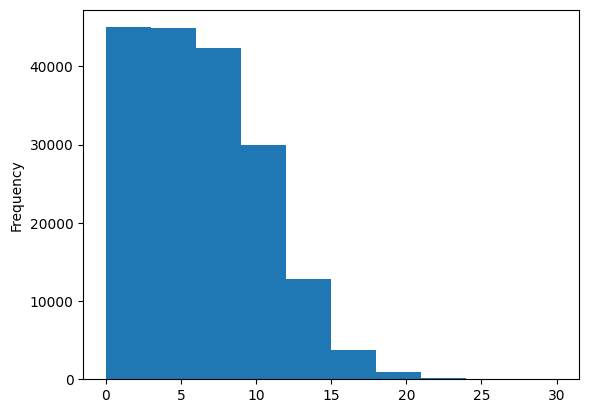

In [73]:
train_df.line_number.plot.hist()

It looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15

In [74]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Setting the `depth` parameter of `tf.one_hot` to 15 means any sample with a `line_number` value of over 15 gets set to a tensor of all 0, where as any sample with a `line_number` of under 15 gets turned into a tensor of all 0 but with a 1 at the index equal to the `line_number` value


We could create a one-hot tensor which has room for all of the potential values of `line_number` (depth=30), however, this would end up in a tensor of double the size of our current one (depth=15) where the bast majority of values are 0. Plus, only ~2.000/180.000 samples have a `line_number` value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the `curse of dimensionality`. However, since this we are working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I will leave exploring values of the `depth` parameter as an extension.

In [76]:
# check one-hot encoded "line_numer" feature sample
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[0]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(15,), dtype=float32, numpy=
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>)

with column `"total_lines"`

In [77]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

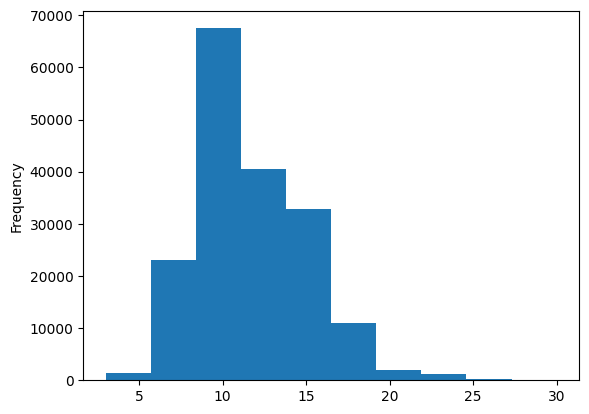

In [78]:
train_df["total_lines"].plot.hist()

the distribution of our "total_lines" column that a value of 20 looks like it covers the majority of samples.

We can confirm this with `np.percentile()`

In [86]:
# check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) #  a value of 20 covers 98% of samples

20.0

Beautiful! Plenty of converage. Let's one-hot-encode our `total_lines` column just as we did before

In [88]:
# Use Tensorflow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape

TensorShape([180040, 20])


### Building  tribrid embedding model
    
Woohoo! Positional embedding tensors ready.
    
It's time to build the biggest model we have build yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We will be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we have going to go through the following steps:
    
    1. Create a token-level model (similar to model_1).
    
    2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
    
    3. Create a `line_number` model (takes in one-hot-encoded `line_number` tensor and passes it through a non-linear layer)
    
    4. Create a `total_lines` model (takes in one-hot-encoded `total_lines` tensor and passes it through a non-linear layer)
    
    5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classiication in Medical Paper Abstract.
    
    6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding.
    
    7. Create an output layer to accept the tribrid embedding and output predicted label probabilities.
    
    8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`
    

In [91]:
# 1. Token inputs 
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                  outputs=x)

# 4. Total lines inputs 
total_line_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                                 outputs=y)

# 5. Combine token and char embedding into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into tribrid embedding 
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                               total_line_model.output,
                                                               z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_line_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer)

In [92]:
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [118]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


------------------------------------------------------------

Visualizing the model makes it much easier to understand.

Essentially what we are doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

You will notice our model is looking very similar to the model shown in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts. However, a few differences still remain:
    
    - We are using pretrained TensorFlow Hub token embeddings instead of GloVe embeddings.
    
    - We are using a Dense layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
    
    - Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it is not shown in Figure 1. To makeup for the lack of this layer in our model, we are created the positional embeddings layers.
    
    - Section 3.2 of the paper mentions the token and character embeddings are updated during trainning, our pretrained TensorFlow Hub embeddings remine frozen.
    
    - The paper uses the `SGD` optimizer, we are going to stick with `Adam`
    
All of the differences above are potential extensions of this project.

In [95]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001FFE2415548> True
<keras.engine.input_layer.InputLayer object at 0x000001FFE206C548> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001FF6D371D88> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x000001FF428A6D08> False
<keras.layers.core.embedding.Embedding object at 0x000001FF6D238B48> True
<keras.layers.core.dense.Dense object at 0x000001FFE2487388> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x000001FFE251DFC8> True
<keras.layers.merging.concatenate.Concatenate object at 0x000001FFE1DD2D48> True
<keras.engine.input_layer.InputLayer object at 0x000001FFE2441888> True
<keras.engine.input_layer.InputLayer object at 0x000001FFE27B9548> True
<keras.layers.core.dense.Dense object at 0x000001FFE2509388> True
<keras.layers.core.dense.Dense object at 0x000001FFE2140148> True
<keras.layers.core.dense.Dense object at 0x000001FFE25C5308> True
<keras.layers.regularization.dropout.

------------------------------------------------------------------
Our model is constructed, let is compile it.

We have going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (orevent overfitting) by making sure it does not get to focused on applying one particular label to a sample.

For example, instead of having an output prediction of:
    
    -`[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).
    
    It's predictions will get smoothed to be somehting like:
    
    -`[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.
    
    For more on label smoothing, greate blog post by PyImageSearch, 
    (https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).

In [97]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

### Create tribrid embedding datasets and fit  tribrid model

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:
    
    1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
    2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
    3. Token-level sequences tensor (`train_sentences`)
    4. Char-level sequences tensor (`train_chars`)
    
We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batch `PrefetchedDataset`

In [103]:
# Create training and validation datasets (all four kind of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                             val_sentences,
                                                             val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [104]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                             epochs=3,
                             validation_data=val_pos_char_token_dataset,
                             validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                             verbose=0)

In [105]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_5_preds)

945/945 [==============================] - 22s 21ms/step


In [106]:
model_5_results

{'accuracy': 83.43704488282802,
 'precision': 0.8336433218866851,
 'recall': 0.8343704488282802,
 'f1': 0.8331303409352201}

Compare model results

Far out, we have come a long way. From a baseline model to training a model containing three different kinds of embeddings. 

Now it is time to compare each model's performance against each other.

We will also able to compare our model's to PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [117]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_result,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.674037,0.783339,0.786740,0.784356
pretrained_token_embed,71.378922,0.714447,0.713789,0.710714
custom_char_embed_conv1d,65.232358,0.643353,0.652324,0.642567
hybrid_char_token_embed,69.766980,0.709059,0.697670,0.696851
tribrid_pos_char_token_embed,83.437045,0.833643,0.834370,0.833130


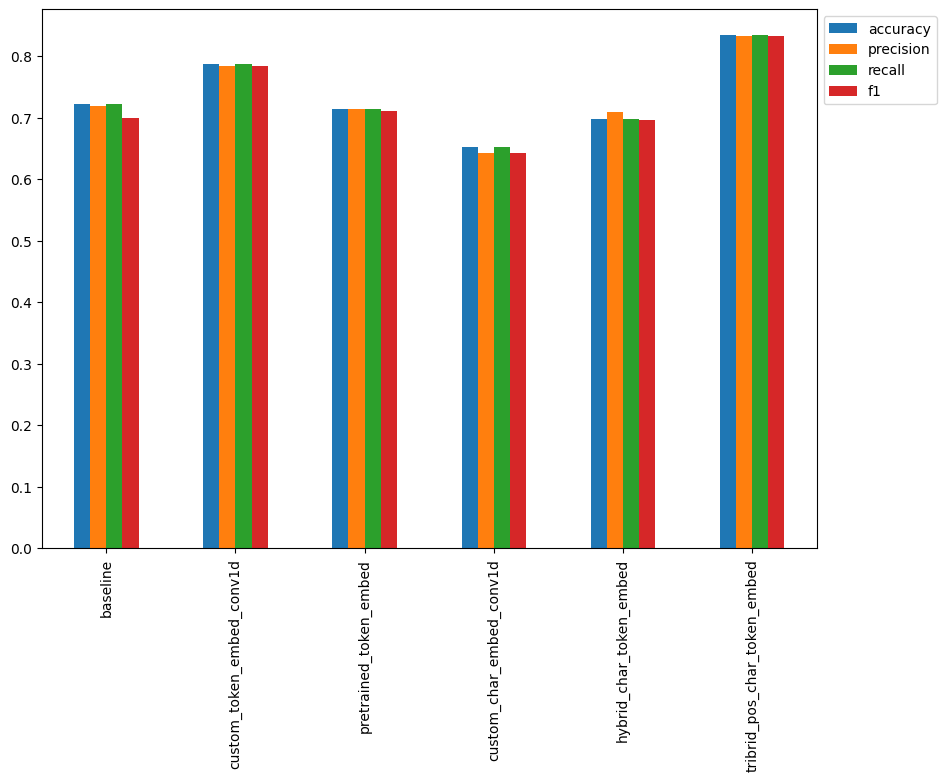

In [120]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compaare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:

    - Our models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~18,000 in the 20k RCT dataset.
        - This is often the case in machine learning experiments though, make sure trainning works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).
    - Our model's prediction performance levels have been evaluated on the validation dataset not the test databse (we will evaluate our best model on the test dataset shortly).
    
### Save and load best performing model

Since we have been through a fair few experiments, it is a good idea to save our best performing model so we can reuse it without having to retrain it.

We can save our best performing model by calling the `save()` method on it.

In [121]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


Like all good cooking shows, we have got a pretrained model (exactly the same kind of model we built for `model_5` save and stored on Google Storage)

So to make sure we are all using the same model for evaluation, we will download it and load it in.

And when loading in our model, since it uses a couple of custom object(our TensorFlow Hub layer and `TextVectorization` layer), we will have to load it in by specifying them in the `custom_objects` parameter of `tf.keras.models.load_model()`.


----------------------------------------------
### Make predictions and evalaute them against the truth labels

To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [124]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 20s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [125]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.43704488282802,
 'precision': 0.8336433218866851,
 'recall': 0.8343704488282802,
 'f1': 0.8331303409352201}

Let's compare our loaded model's predictions with the prediction results we obtained before saving our model.

In [129]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

It's worth noting that loading in a SavedModel unfreezes all layers (make them all trainable). So if you want to freeze any layers, you will have to set their trainable attribute to `False`.

In [133]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model = model_5
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

Evaluate model on test dataset

To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [135]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [136]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                      verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 25s 26ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0], dtype=int64)>

In [137]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                             y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.96333167413307,
 'precision': 0.8283806746632603,
 'recall': 0.8296333167413307,
 'f1': 0.828287097671159}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.1 F1-score on the test dataset, where as ours gets 82.1 Fi-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there is a couple of extensions we could try to improve our results.

### Find most wrong

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help is visualize the most wrong predictions from the test dataset.

Frist we will convert all of our integer-based test predictions into their string-based class names.

In [138]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

Wall time: 6.98 s


Now we will enrich our test DataFrame with a few values:

    - A `"prediction"` (string) column containing our model's prediction for a given sample.
    - A `"pred_prob"` (float) column containing the model's maximum prediction probability for a given sample.
    - A `"correct"` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [139]:
# Create production-enriched test dataframe
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.540891,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.340717,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.799080,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.648001,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.732175,True


Having our data like this, makes it very easy to manipulate and view in different ways.

How about we sort our DataFrame to find the samples with the highest "pred_prod" and where the prediction was wrong "correct" == False"

In [141]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.936370,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.935220,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.929654,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.925114,False
697,RESULTS,a screening questionnaire for moh was sent to ...,4,14,METHODS,0.919426,False


We got a subset of our model's most wrong predictions, let's write some code to visualize them.

In [142]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
    _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")
    break

Target: RESULTS, Pred: METHODS, Prob: 0.9363704919815063, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----



What do you notice about the most wrong predictions? Dose the model make silly mistakes? or are some of the labels incorrect/ambiguous (e.g a line in an abstract could potentially be labelled `OBJECTIVE` or `BACKGROUND` and make sense).

A next step here world be if there are a fair few samples with inconsistent labels, you could go through your trainning dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as active learning.

### Make example predictions

We have made some predictions on the test dataset, now's time to really test our model out.

To do so, we are going to get some data from the wild and see how our model performs. 

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we will need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you will notice many of the basracts are already preformatted into separate sections, this helps dramatically with readability).

Going through various PubMed studies, I managed to find the following unstructured abstract from `RCT of a manualized social treatment for high-functioning autism spectrum disorders`:

This RCT examined the effcacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary meansures based on staff ratings (treatment group only) corroborated gains reported by parents. Hign levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine you are a medical researcher trying to skim through the literature to find a study relevant to your work.

Sources like quite the challenge right?

Enter SkimLit!

Let's see what our best model so far (`model_5`) makes of the above abstract.

But wait...

As you might have guessed the above abstract hasnot been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we will need to: 

    1. Split it into sentences (lines).
    2. Split it into characters.
    3. Find the number of each line.
    4. Find the total number of lines.
    
Starting with number 1, there are a couple of ways to split our  abstracts into actual sentences. A simple one would be to use Python's in-build `split()` string method, splitting the abstract wherever a fullstop appears. However, can you imagine where this might go wrong?

Another more advanced option would be to leverage `spaCy's` (a very powerful NLP library) `sentencizer` class. Which is an easy to use sentence splitter based on spaCy's English language model.

I have prepared some abstracts from PubMed RCT papers to try our model on, we can download them `from GitHub`.
